# Лаба 2

**Дедлайн**: 25 ноября

**Задача**: написать определитель тональности текста (сообщениея в Twitter) c помощью fine-tuning-а на датасете RuSentiTweet (https://github.com/sismetanin/rusentitweet)

На что обратить внимание:
(+)Подготовка данных (очистка, токенизация и упаковка датасета в удобный класс) - у вас в задании другой датасет, соответственно обработка может поменяться. В датасете несколько файлов, скачайте rusentitweet_full.csv и работайте с ним
(-)Процедура дообучения. Вам необходимо доработать имеющуюся процедуру:
    --(-) Добавить графики качества обучения модели в зависимости от шага (делать валидацию каждые 100 шагов (например), а не раз в эпоху)
    --(+) Замерить время обучения
    --(-) Добавить больше метрик для отслеживания (изучите по открытым источникам, какие метрики используются для задачи определения тональности и почему)
    --(-) Добавить заморозку части слоев (все, кроме слоя классификации, или кроме слоя классификации + 2-3 последних слоев с интентами)
    --(-) Подобрать количество эпох, размер батча и заморозку так, чтобы модель давала лучший результат
(-)Модель для дообучения (попробуйте как минимум 2 разных модели), искать подходящие модели можно с помощью гугла и https://huggingface.co/
(+)Результаты **всех** экспериментов должны быть описаны в отдельной ячейке
(+)Inference модели - обученную модель нужно обернуть в удобную функцию для использования, которая по тексту будет возвращать его тональность


https://www.youtube.com/watch?v=xI0HHN5XKDo

## Импорты

In [1]:
import typing, re, torch, os.path, sys, emot, torchmetrics

from torch.utils.data.dataset import T_co

# костыль, чтоб общий файлик сгрузить
if not sys.path.__contains__('..'):
    sys.path.insert(0, '..')
import helper

from num2words import num2words
from cleantext import clean
from pathlib import Path

from torch.utils.data import TensorDataset, DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

emot_core = emot.core.emot()

In [2]:
import importlib

importlib.reload(helper)

<module 'helper' from 'C:\\Users\\anast3t\\Desktop\\all\\coding\\neural-networks\\Task2\\..\\helper.py'>

## Константы

In [3]:
SEED = 42
BATCH_SIZE = 32
SPLIT_SIZE = 0.3
NUM_WORKERS = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

## Очистка данных

Разберемся с данными - уберем ненужные колонки, символы и т.д.

In [4]:
# Как всегда - на все случаи жизни есть библиотечки.
# Однако зачем-то я решил настолько очисткой заморочиться, что даже эмотиконы вытащил, и вот на это библиотек не было

def num2words_with_extract(text: typing.AnyStr) -> typing.AnyStr:
    split_text = text.split(' ')
    for idx, segment in enumerate(split_text):
        if segment.isdigit():
            split_text[idx] = num2words(segment, lang='ru')
    return " ".join(split_text)


def remove_emoticons(text: typing.AnyStr, emot_core) -> typing.AnyStr:  # TODO: write your own emoticon regexp
    res = emot_core.emoticons(text)
    for emoticon in res['value']:
        # print(emoticon)
        regex = '(?:'
        for symbol in [*emoticon]:
            regex += (symbol if symbol.isalpha() or symbol.isdigit() else '\\' + symbol) + '+'
        regex += ')'
        # print(regex)
        compiled = re.compile(regex)
        text = compiled.sub(r'', text)
    return text


def clean_text(text: typing.AnyStr, emot_core=emot_core) -> typing.AnyStr:
    text = clean(
        text=text,
        fix_unicode=False,  # fix various unicode errors
        to_ascii=False,  # transliterate to closest ASCII representation
        lower=True,  # lowercase text
        no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
        no_urls=True,  # replace all URLs with a special token
        no_emails=True,  # replace all email addresses with a special token
        no_phone_numbers=True,  # replace all phone numbers with a special token
        no_emoji=True,
        no_numbers=False,  # replace all numbers with a special token
        no_digits=False,  # replace all digits with a special token
        no_currency_symbols=False,  # replace all currency symbols with a special token
        no_punct=False,  # remove punctuations
        normalize_whitespace=True,
        replace_with_punct="",  # instead of removing punctuations you may replace them
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        # lang="en"                       # set to 'de' for German special handling
    )
    tag_pattern = re.compile("@\S+")
    dot_pattern = re.compile("\.{2,}")
    text = tag_pattern.sub(r'', text)  # убираем теги юзеров
    text = dot_pattern.sub(r'', text)  # убираем многоточия (на всякий случай, тк их много)
    text = remove_emoticons(text, emot_core)  # убираем эмотиконы типа :) :-(((
    text = num2words_with_extract(text)  # преобразуем цифры в текст
    return " ".join(text.split())  # normalize whitespaces


# пример отработки
clean_text(
    "@varlamov @McFa__ul bortnikov@mail.ru На Ой какие неожиданные ::-( :333 100 .......... результаты 🤭 https://t.co/ZwOHPDKUqq 88005553535",
    emot_core)

'на ой какие неожиданные сто результаты'

In [5]:
twitter_cut = None
csv_path = Path("csv")
twitter_full_path = csv_path / "twitter_full.csv"
twitter_cut_path = csv_path / "twitter_cut.pickle"

twitter = pd.read_csv(twitter_full_path)

if not os.path.exists(twitter_cut_path):
    print("Clearing initial csv and saving to pickle")
    twitter_cut = twitter.drop(["id", "Unnamed: 0"], inplace=False, axis=1)  # .rename(columns={"Unnamed: 0": "index"})
    twitter_cut = twitter_cut[twitter_cut["label"] != "skip"]
    twitter_cut = twitter_cut.reset_index()
    twitter_cut.rename(columns={"index": "old_idx"}, inplace=True)
    twitter_cut["text_clean"] = twitter_cut["text"].apply(clean_text)
    twitter_cut.to_pickle(twitter_cut_path)
else:
    print("Loading existing pickle")
    twitter_cut = pd.read_pickle("./csv/twitter_cut.pickle")


Loading existing pickle


In [6]:
# twitter.head(10)

In [7]:
twitter_cut.head(100)

,old_idx,text,label,text_clean
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар..."
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д..."
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина
...,...,...,...,...
95,110,@snakey_ssnake Делать еще ╰(‵□′)╯ (мне понрави...,positive,делать еще ╰(‵□′)╯ (мне понравилось)
96,112,@cerealporridge 😭😭😭😭♥️♥️♥️♥️ спасибо 😭♥️♥️♥️♥️,speech,спасибо
97,114,В СевГУ прошел круглый стол по случаю Дня соли...,neutral,в севгу прошел круглый стол по случаю дня соли...
98,115,"@great_knee Бро,моя тоже",neutral,"бро,моя тоже"


In [8]:
def label_to_int(label):
    if label == 'negative':
        return 0
    elif label == 'neutral' or label == 'speech':
        return 1
    elif label == 'positive':
        return 2


twitter_cut["num_label"] = twitter_cut["label"].apply(label_to_int)

twitter_cut

,old_idx,text,label,text_clean,num_label
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...,0
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар...",0
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты,1
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д...",1
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина,1
...,...,...,...,...,...
11544,13386,Это просто промокод и он одноразовый! https://...,neutral,это просто промокод и он одноразовый!,1
11545,13387,все пора спать пиздец словила шизу,negative,все пора спать пиздец словила шизу,0
11546,13388,такими темпами я создам новую секту или органи...,neutral,такими темпами я создам новую секту или органи...,1
11547,13389,"Ты смотрела аниме, завернувшись в одеяло ,пока...",neutral,"ты смотрела аниме, завернувшись в одеяло ,пока...",1


[Text(0, 0, 'neg'), Text(1, 0, 'neu'), Text(2, 0, 'pos')]

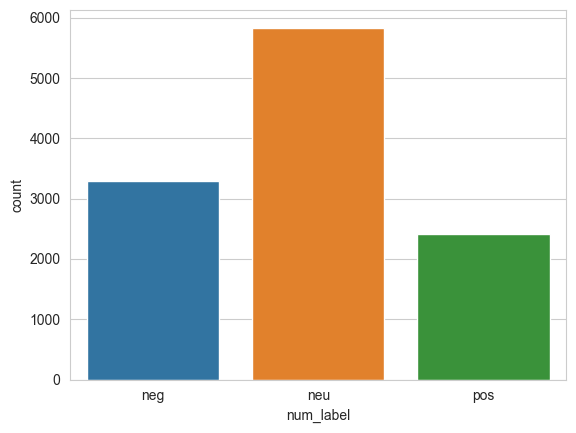

In [9]:
ax = sns.countplot(data=twitter_cut, x="num_label")
ax.set_xticklabels(["neg", "neu", "pos"])

Из-за того, что speech ушел в neutral, то у нас возникает дисбаланс (возможно с этим стоило что-то сделать)

## Высокоуровневая предобработка

Сначала попробуем дистиллированную модель https://habr.com/ru/articles/562064/

In [10]:
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path="cointegrated/rubert-tiny")

In [11]:
def tokenize(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    return pd.Series([encoding["input_ids"], encoding["attention_mask"]])

Вроде как можно написать кастомный класс датасета, но вроде как можно и не писать, так и не понял пока

In [12]:
twitter_cut[["input_ids", "attention_mask"]] = twitter_cut["text_clean"].apply(tokenize)

Разделяем на трейн/тест

In [13]:
train_df, test_df = train_test_split(
    twitter_cut,
    test_size=SPLIT_SIZE,
    shuffle=True,
    stratify=twitter_cut['num_label'].values,
    random_state=SEED
)

train_dataset, test_dataset, train_dataloader, test_dataloader = helper.prepare_ds_dl_transformer(
    train_dataframe=train_df,
    test_dataframe=test_df,
    label_field_name="num_label",
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

## Кидаем все это в модель

In [14]:
f1 = torchmetrics.F1Score(
    task="multiclass",
    num_classes=3,
    device=device
).to(device)

In [15]:
# Заметка для себя - параметры тут https://huggingface.co/transformers/v2.9.1/main_classes/configuration.html

def rubert_tiny_trainer(
        epochs: int,
        lr: float,
        file_name: typing.AnyStr,
        force_override: bool,
        scheduler_gamma: float or None = None,
):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    rubert_tiny = BertForSequenceClassification.from_pretrained(
        pretrained_model_name_or_path="cointegrated/rubert-tiny",
        num_labels=3
    ).to(device)

    rubert_tiny.name = file_name

    rubert_optimizer = torch.optim.AdamW(
        rubert_tiny.parameters(),
        lr=lr,
    )
    scheduler = None
    if scheduler_gamma is not None:
        scheduler=torch.optim.lr_scheduler.ExponentialLR(
            optimizer=rubert_optimizer,
            gamma=scheduler_gamma,
            verbose=True
        )

    return helper.model_trainer_with_saving(
        model=rubert_tiny,
        epochs=epochs,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        loss_function=None,
        optimizer=rubert_optimizer,
        eval_function=f1,
        device=device,
        file_name=file_name,
        scheduler=scheduler,
        transformer=True,
        force_override=force_override,
        models_folder='models',
        res_folder='model_res'
    )

class_names = ["negative", "neutral", "positive"]

def rubert_tiny_results_show(rubert_model, rubert_results):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    helper.model_eval_report(
        model=rubert_model,
        test_dataloader=test_dataloader,
        test_dataset=test_dataset,
        loss_function=None,
        eval_function=f1,
        device=device,
        transformer=True,
        class_names=class_names
    )
    # plt.rcParams['figure.figsize'] = [6, 5]
    ax1.plot(rubert_results.history_test_loss[0], label='test_loss')
    ax1.plot(rubert_results.history_train_loss[0], label='train_loss')
    ax1.set_title('loss')
    ax1.legend()
    # plt.rcParams['figure.figsize'] = [6, 5]
    ax2.plot(rubert_results.history_test_eval[0], label='test_eval')
    ax2.plot(rubert_results.history_train_eval[0], label='train_eval')
    ax2.set_title('eval')
    ax2.legend()


In [16]:
rubert_tiny1, rubert_tiny_results1 = rubert_tiny_trainer(
    epochs=15,
    lr=3e-5,
    force_override=False,
    file_name="rubert_tiny_ep15_lr3e-5"
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Loading existing model


Как можно заметить - самому добавлять слои не пришлось, на выходе 3 фичи

Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

C:\Users\anast3t\Desktop\all\coding\neural-networks\Task2\..\helper.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(test_dataset.targets if not transformer else test_dataset.tensors[2])


              precision    recall  f1-score   support

    negative       0.59      0.65      0.62       990
     neutral       0.74      0.68      0.71      1751
    positive       0.54      0.57      0.56       724

    accuracy                           0.65      3465
   macro avg       0.62      0.63      0.63      3465
weighted avg       0.66      0.65      0.65      3465



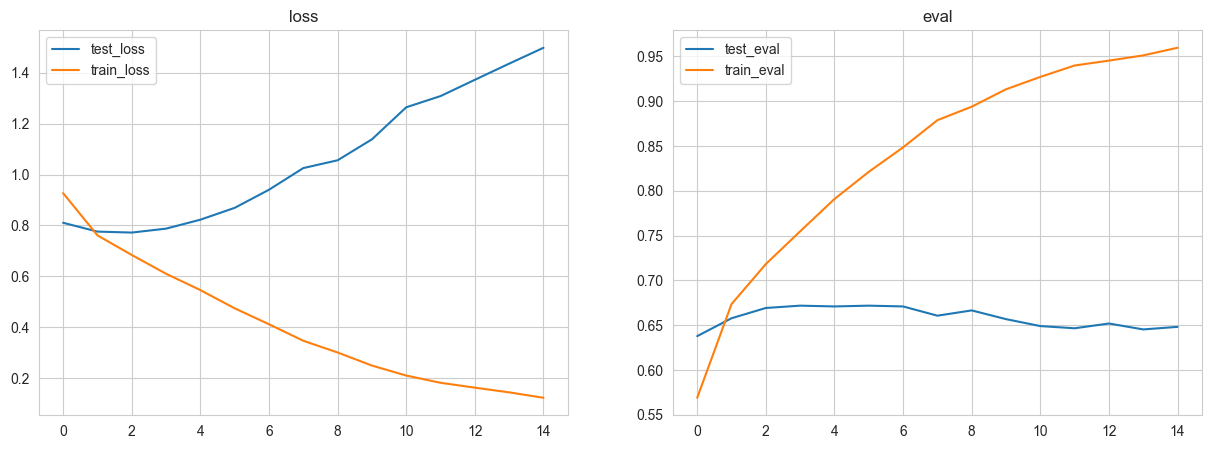

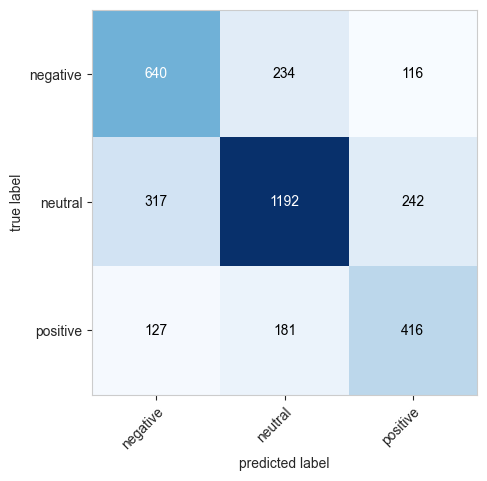

In [17]:
rubert_tiny_results_show(
    rubert_tiny1,
    rubert_tiny_results1
)

Наблюдаем очевиднейший оверфит?... Попробую уменьшить скорость обучения

In [18]:
rubert_tiny2, rubert_tiny_results2 = rubert_tiny_trainer(
    epochs=15,
    lr=3e-6,
    force_override=False,
    file_name="rubert_tiny_ep15_lr3e-6"
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Loading existing model


Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

C:\Users\anast3t\Desktop\all\coding\neural-networks\Task2\..\helper.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(test_dataset.targets if not transformer else test_dataset.tensors[2])


              precision    recall  f1-score   support

    negative       0.56      0.65      0.60       990
     neutral       0.72      0.71      0.72      1751
    positive       0.60      0.49      0.54       724

    accuracy                           0.65      3465
   macro avg       0.63      0.62      0.62      3465
weighted avg       0.65      0.65      0.65      3465



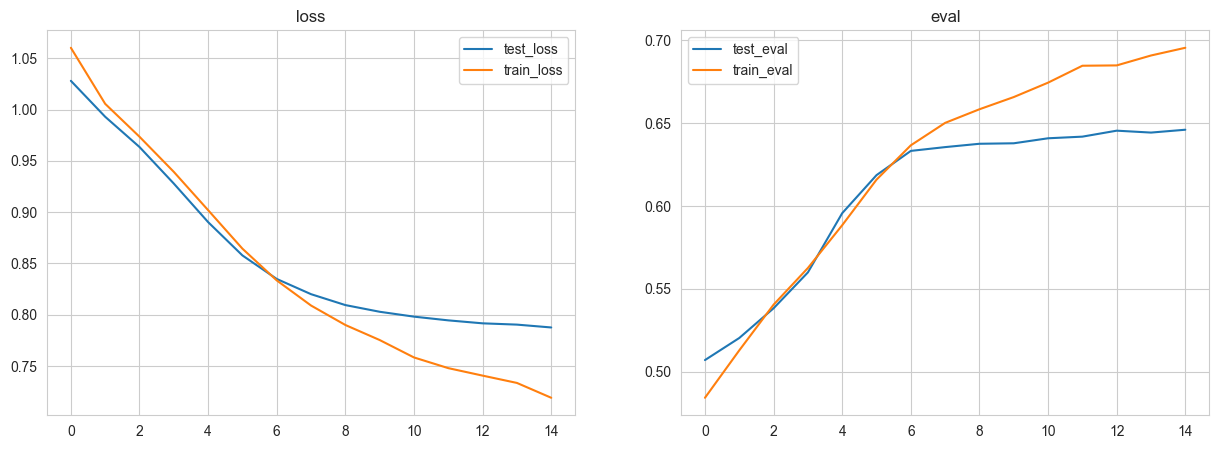

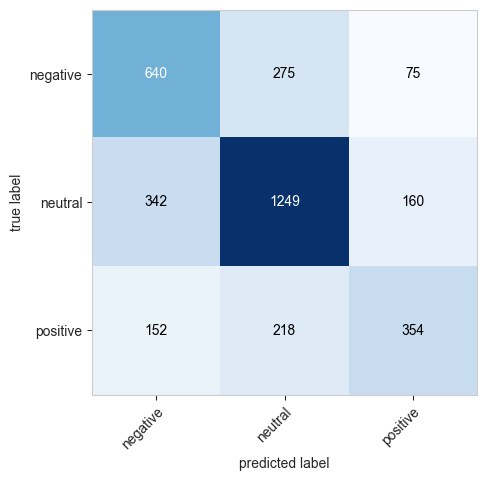

In [19]:
rubert_tiny_results_show(
    rubert_tiny2,
    rubert_tiny_results2
)

Получше, но все равно глохнет на 65%, попробую расписание добавить

In [20]:
rubert_tiny3, rubert_tiny_results3 = rubert_tiny_trainer(
    epochs=15,
    lr=3e-5,
    scheduler_gamma=0.5,
    force_override=False,
    file_name="rubert_tiny_ep15_lr3e-5_gamma50"
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Adjusting learning rate of group 0 to 3.0000e-05.
Loading existing model


Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

C:\Users\anast3t\Desktop\all\coding\neural-networks\Task2\..\helper.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(test_dataset.targets if not transformer else test_dataset.tensors[2])


              precision    recall  f1-score   support

    negative       0.58      0.64      0.61       990
     neutral       0.72      0.73      0.73      1751
    positive       0.61      0.52      0.56       724

    accuracy                           0.66      3465
   macro avg       0.64      0.63      0.63      3465
weighted avg       0.66      0.66      0.66      3465



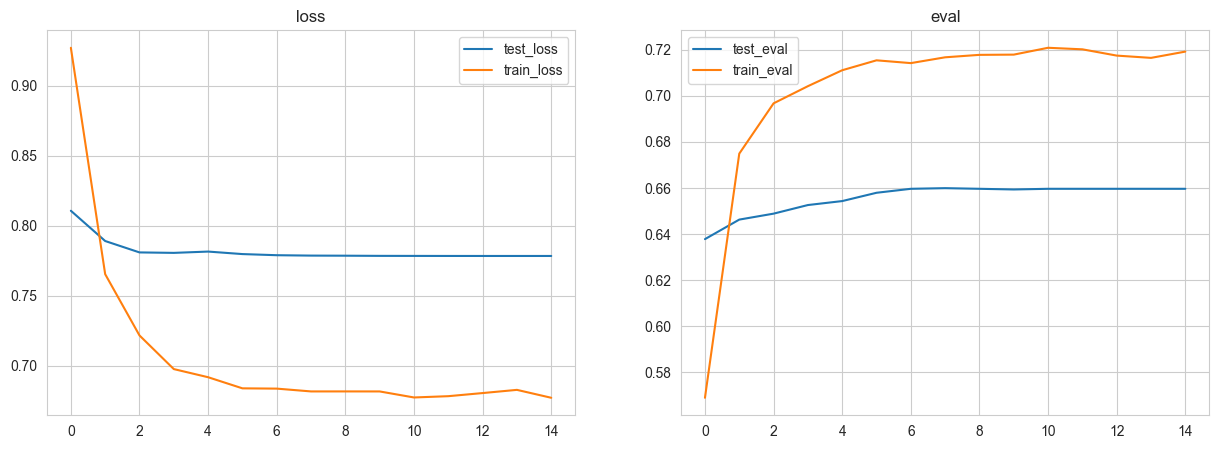

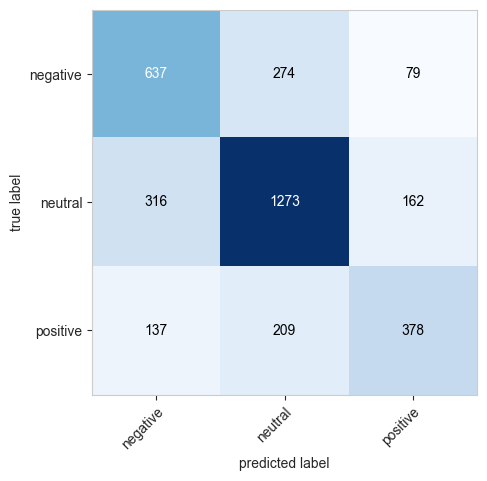

In [21]:
rubert_tiny_results_show(
    rubert_tiny3,
    rubert_tiny_results3
)

Результаты лучше, но гамма будто большая, гасится раньше положенного

In [22]:
rubert_tiny4, rubert_tiny_results4 = rubert_tiny_trainer(
    epochs=15,
    lr=3e-5,
    scheduler_gamma=0.75,
    force_override=False,
    file_name="rubert_tiny_ep15_lr3e-5_gamma75"
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Adjusting learning rate of group 0 to 3.0000e-05.
Loading existing model


Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

C:\Users\anast3t\Desktop\all\coding\neural-networks\Task2\..\helper.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(test_dataset.targets if not transformer else test_dataset.tensors[2])


              precision    recall  f1-score   support

    negative       0.59      0.67      0.63       990
     neutral       0.75      0.72      0.73      1751
    positive       0.60      0.55      0.57       724

    accuracy                           0.67      3465
   macro avg       0.64      0.64      0.64      3465
weighted avg       0.67      0.67      0.67      3465



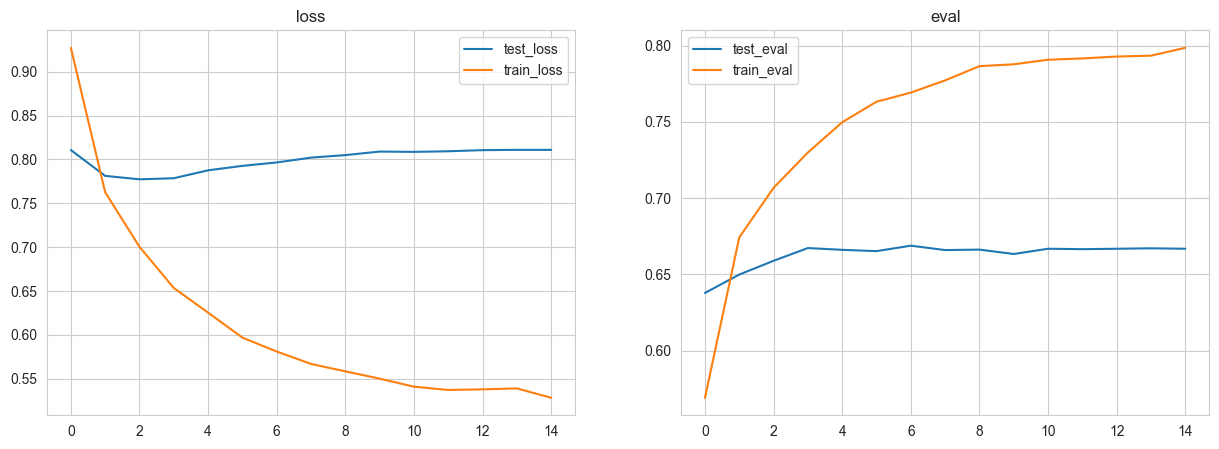

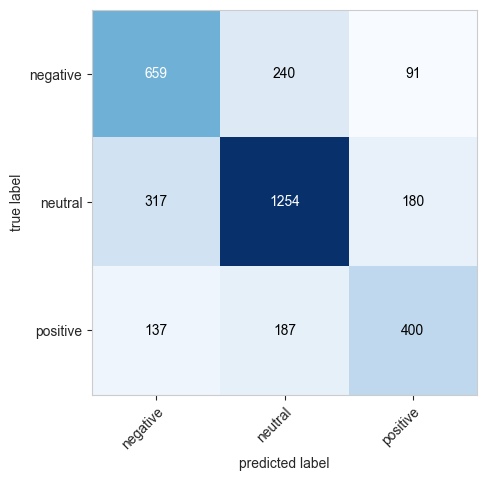

In [23]:
rubert_tiny_results_show(
    rubert_tiny4,
    rubert_tiny_results4
)

Примерно то же самое, но лосс на тесте рос, поэтому 0.5 гаммы было оптимально видимо

#### Check overfit

In [ ]:
rubert_tiny_OF, rubert_tiny_results_OF = rubert_tiny_trainer(
    epochs=50,
    lr=5e-6,
    force_override=False,
    file_name="rubert_tiny_ep50_lr5e-6_OVERFIT_TEST"
)

Train batches:   0%|          | 0/109 [00:00<?, ?it/s]

C:\Users\anast3t\Desktop\all\coding\neural-networks\Task2\..\helper.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(test_dataset.targets if not transformer else test_dataset.tensors[2])


              precision    recall  f1-score   support

    negative       0.58      0.68      0.62       990
     neutral       0.75      0.68      0.71      1751
    positive       0.57      0.56      0.56       724

    accuracy                           0.65      3465
   macro avg       0.63      0.64      0.63      3465
weighted avg       0.66      0.65      0.66      3465



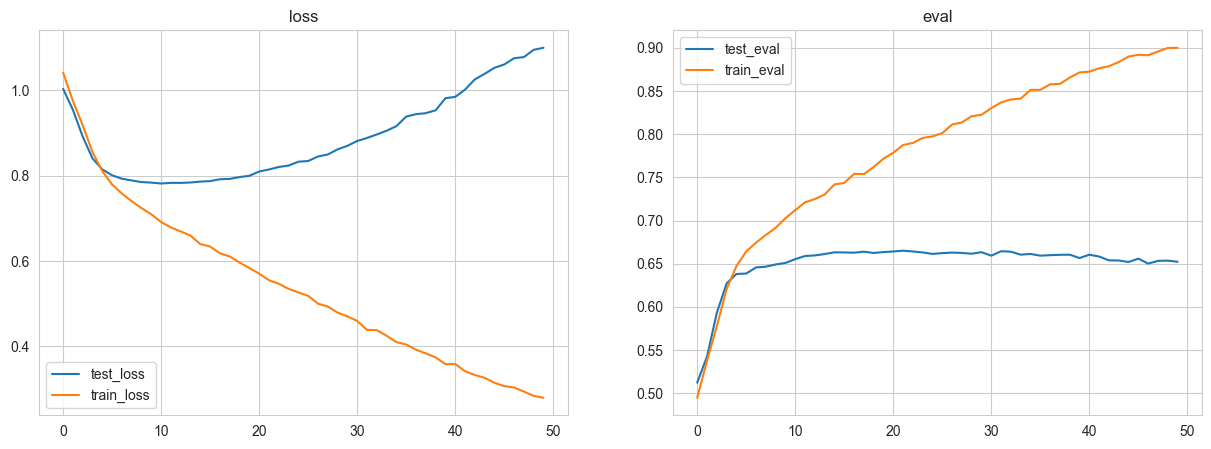

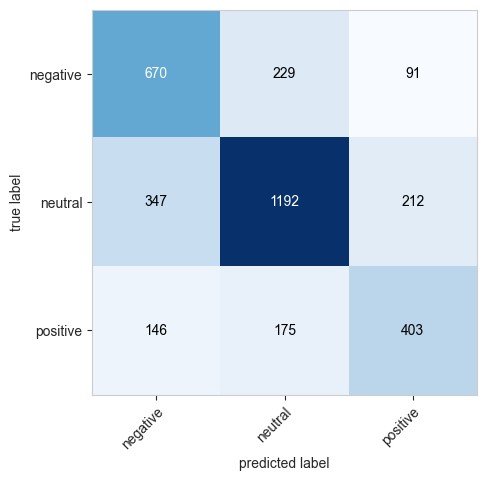

In [32]:
rubert_tiny_results_show(
    rubert_tiny_OF,
    rubert_tiny_results_OF
)

## Double descend

В общем на лекции нам расказали про эффект двойного спуска, меня это заинтересовало, прочитал оригинальную бумагу и решил проверить. Кинул на 5000 эпох, оставил коптиться на ~6 часов, в итоге компьютер скис с блускрином на 3000 эпохе. Поведения двойного спуска не было, тестлосс продолжал рости и никак не хотел разворачиваться обратно. Скорее всего, потому что дистилированная модель не оверпараметризованная и нужно брать берт/бертлардж для наблюдения эффекта. В сторону именно берта не копал, но по изначальной статье эффект должен наблюдаться и у трансформеров.

In [26]:
# rubert_tiny, rubert_tiny_results = rubert_tiny_trainer(
#     epochs=5000,
#     lr=3e-6,
#     force_override=False,
#     file_name="rubert_tiny_ep5000_lr3e-6"
# )

In [27]:
# rubert_tiny_results_show(
#     rubert_tiny,
#     rubert_tiny_results
# )

составим табличку результатов по rubert_tiny

In [28]:
rubert_tiny_all = pd.concat([rubert_tiny_results1, rubert_tiny_results2, rubert_tiny_results3, rubert_tiny_results4])
rubert_tiny_all

,name,class_name,status,epochs_remain,on_which_batch_broken,train_time,loss_function,optimizer,learning_rate,eval_function,device,end_test_loss,end_test_eval,end_train_loss,end_train_eval,history_test_loss,history_test_eval,history_train_loss,history_train_eval
0,rubert_tiny_ep15_lr3e-5,BertForSequenceClassification,TrainStatus.Success,0,None,84.419073,NoneType,AdamW,3.000000e-05,MulticlassF1Score,cuda,1.498644,0.648159,0.122758,0.959536,"[0.81073, 0.77603, 0.7722, 0.78766, 0.82281, 0...","[0.63781, 0.65775, 0.66922, 0.6718, 0.67094, 0...","[0.92728, 0.76131, 0.68418, 0.61027, 0.54613, ...","[0.56902, 0.67354, 0.71821, 0.75472, 0.79079, ..."
0,rubert_tiny_ep15_lr3e-6,BertForSequenceClassification,TrainStatus.Success,0,None,80.687391,NoneType,AdamW,3.000000e-06,MulticlassF1Score,cuda,0.787649,0.645993,0.719137,0.695405,"[1.02799, 0.99297, 0.96351, 0.92789, 0.89032, ...","[0.50707, 0.52039, 0.53832, 0.55995, 0.59566, ...","[1.06019, 1.00558, 0.97351, 0.93928, 0.90197, ...","[0.48434, 0.51294, 0.54049, 0.5626, 0.58841, 0..."
0,rubert_tiny_ep15_lr3e-5_gamma50,BertForSequenceClassification,TrainStatus.Success,0,None,80.672499,NoneType,AdamW,9.155273e-10,MulticlassF1Score,cuda,0.778388,0.659627,0.676965,0.719121,"[0.81073, 0.78908, 0.78093, 0.7806, 0.78153, 0...","[0.63781, 0.64628, 0.64886, 0.65259, 0.65431, ...","[0.92728, 0.76537, 0.72155, 0.69749, 0.69167, ...","[0.56902, 0.67488, 0.69669, 0.70413, 0.71104, ..."
0,rubert_tiny_ep15_lr3e-5_gamma75,BertForSequenceClassification,TrainStatus.Success,0,None,81.819096,NoneType,AdamW,4.009038e-07,MulticlassF1Score,cuda,0.810899,0.666794,0.528303,0.798641,"[0.81073, 0.78125, 0.77734, 0.77857, 0.7876, 0...","[0.63781, 0.64985, 0.65889, 0.66724, 0.66609, ...","[0.92728, 0.7626, 0.70039, 0.65345, 0.62534, 0...","[0.56902, 0.67421, 0.70677, 0.72994, 0.74978, ..."


In [29]:
def predict(text, model):
    model.eval()
    with torch.inference_mode():
        text = clean_text(text)
        print(text)
        tokenized = tokenize(text)
        tokenized[0] = tokenized[0].to(device)
        tokenized[1] = tokenized[1].to(device)
        evaluated = model(tokenized[0], token_type_ids=None, attention_mask=tokenized[1])
        print(class_names[torch.argmax(evaluated.logits, dim=-1).detach().cpu().numpy()[0]])

In [87]:
predict("че сказал бля повтори", rubert_tiny3)

че сказал бля повтори
negative
